# 🤖 Transformers & Attention Mechanism

**Master the architecture that powers modern AI**

In this notebook, you'll build deep intuition for how attention works and why transformers have revolutionized AI.  
We'll progress from simple examples to using state-of-the-art models like BERT, GPT, and T5.

---

## What You'll Learn

1. **Why attention matters** - See how it solves the fundamental limitations of RNNs
2. **How attention works** - Understand the Query-Key-Value mechanism with clear visuals
3. **Multi-head attention** - Learn why multiple attention heads capture richer patterns
4. **Transformer architecture** - Connect the pieces into encoder and decoder blocks
5. **Apply pretrained models** - Use transformers for real tasks with Hugging Face

**Prerequisites:** Familiarity with embeddings (Notebook 02) and basic PyTorch (Notebook 03)

**Duration:** 90-120 minutes

# 0. Setup & Motivation

### Why Do We Need Transformers?

Consider this sentence:

> *"The animal didn't cross the street because **it** was too tired."*

What does **"it"** refer to?  
The animal, of course!  
But for a neural network to understand this, it needs to connect "it" (position 7) with "animal" (position 1) - that's a long-range dependency.  
Take a look at an example below and see how RNN (sequential words processing) vs Transformers (attention/parallel processing) looks:

![](./assets/rnn_vs_transformers.png)

**The RNN Problem:**
- RNNs process sequences one step at a time: word₁ → word₂ → word₃ → ...
- Information from word₁ must pass through ALL intermediate steps to reach word₇
- This creates a **bottleneck**: early information gets compressed and lost

**The Transformer Solution:**
- Every word can directly "look at" every other word in parallel
- Word₇ can directly attend to word₁ without going through steps 2-6
- Much faster and better at capturing long-range dependencies

Let's see how this revolutionized AI! 🚀

In [1]:
# Core imports
import os
import sys
import math
import warnings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# Transformers library
from transformers import AutoTokenizer, AutoModel, pipeline

# Add helpers to path
sys.path.append(os.path.dirname(os.getcwd()))
from helpers.transformers import (
    plot_evolution_timeline, 
    plot_rnn_vs_transformer,
    create_causal_mask,
    visualize_causal_masking,
    visualize_attention_heads,
    plot_transformer_architectures
)

# Configure environment
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)

# Set numpy print options to prevent line wrapping
np.set_printoptions(linewidth=200, suppress=True)

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    
torch.set_printoptions(linewidth=200, sci_mode=False)

print(f"✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

✅ Setup complete!
PyTorch version: 2.8.0+cu128
Device: CPU


### The Evolution of Sequence Models

Let's visualize how we got from RNNs to modern transformers:

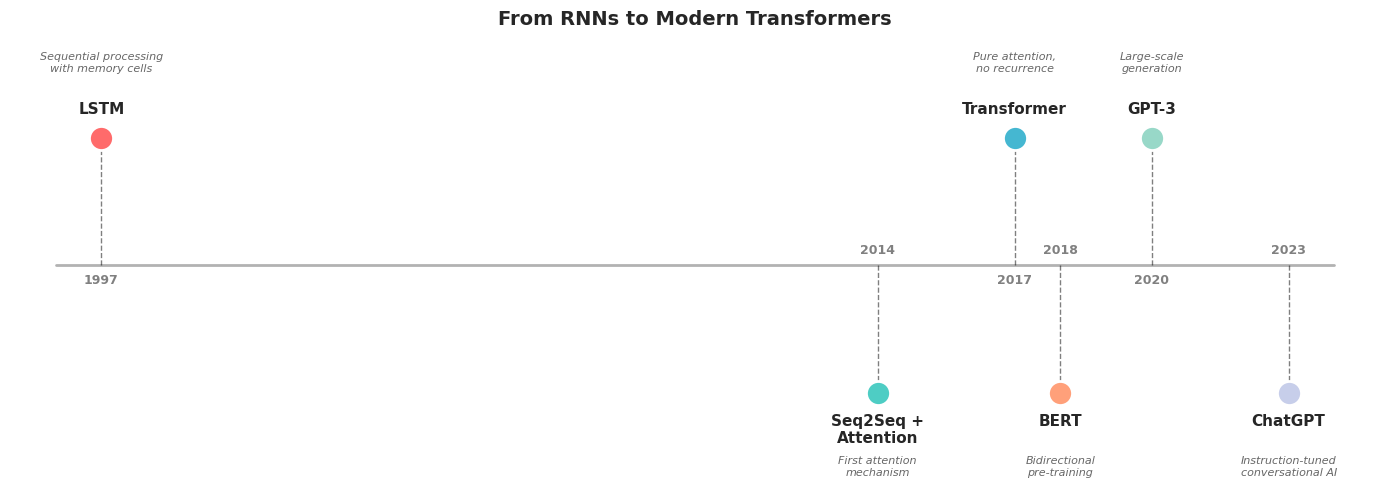

Key Insight: The 2017 'Attention Is All You Need' paper eliminated recurrence entirely!
This unlocked parallelization and enabled models to scale to billions of parameters.


In [2]:
# Visualize the evolution of sequence models
plot_evolution_timeline()

### Understanding the Information Bottleneck

When RNNs process sequences, they maintain a **hidden state** - a fixed-size vector that tries to capture all the important information seen so far. This creates a fundamental problem:

**The Bottleneck Problem:**
- As the sequence gets longer, the hidden state must compress more and more information
- Early information gets repeatedly transformed and can be lost or distorted
- The network must decide what to "remember" and what to "forget" at each step
- This is like trying to summarize a whole book into a single paragraph - crucial details get lost!

**Example:** In "The animal didn't cross the street because it was too tired"
- By the time we reach "it", the RNN has processed 7 words
- Information about "animal" has passed through 6 transformations
- Each transformation risks losing or distorting that information
- The longer the distance, the harder it is to maintain the connection

**Transformers solve this** by allowing direct connections between any two words, no matter how far apart they are. Let's visualize this difference:

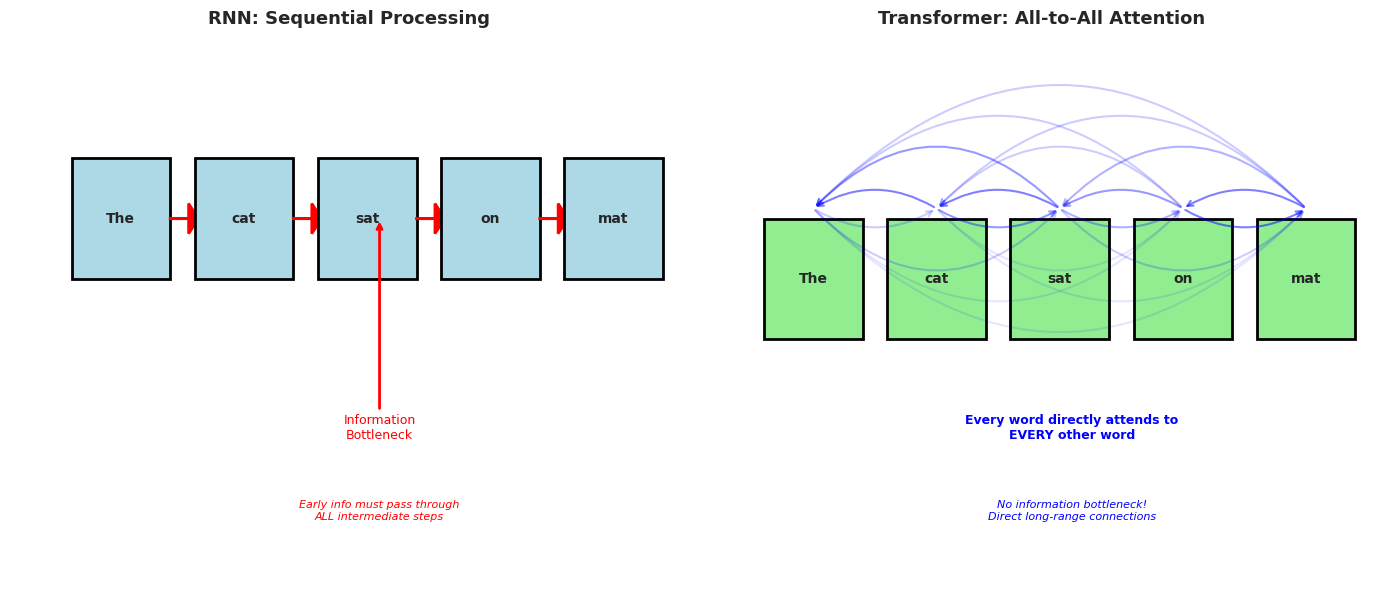

🔑 Key Differences:
   RNN: Sequential processing → Information bottleneck → Slow
   Transformer: Parallel processing → Direct connections → Fast & effective

Notice: In the transformer, you can see connections going in ALL directions,
        showing that each word can attend to every other word simultaneously!


In [3]:
# Compare RNN sequential processing vs Transformer parallel attention
plot_rnn_vs_transformer()

### Why This Matters in Practice

The ability to process sequences in parallel and maintain direct connections has revolutionary implications:

**1. Training Speed**
- RNNs: Must process word-by-word → Can't parallelize → Slow training
- Transformers: Process all words at once → Highly parallelizable → Fast training on GPUs

**2. Long-Range Dependencies**
- RNNs: Struggle with dependencies >10-20 words apart
- Transformers: Can handle dependencies across 100s or 1000s of words

**3. Scalability**
- RNNs: Hit diminishing returns as you make them bigger
- Transformers: Scale beautifully to billions of parameters (GPT-3 has 175B!)

This is why transformers have become the foundation for:
- 💬 **Language Models**: ChatGPT, Claude, Gemini
- 🔍 **Search**: Google BERT for understanding queries
- 🌐 **Translation**: Modern translation systems
- 📝 **Summarization**: Automatic document summarization
- 💻 **Code Generation**: GitHub Copilot, CodeLlama
- 🖼️ **Vision**: Even image models (Vision Transformers)

Now let's dive into **how** attention actually works! 🚀

# 1. Attention Intuition

Now that we understand *why* transformers are powerful, let's dive into *how* they work. At the heart of transformers is the **attention mechanism**.  
There's a good [video by 3Blue1Brown talking about attention in transformers](https://www.youtube.com/watch?v=eMlx5fFNoYc) which I highly recommend as a start.

### The Database Search Analogy

Think of attention like searching a database:

**Imagine you're in a library looking for information about "neural networks":**

1. 🔍 **Query**: Your search request - "I want books about neural networks"
2. 🔑 **Keys**: Book titles and descriptions - what each book offers
3. 📚 **Values**: The actual book content - the information you'll retrieve

**How it works:**
- You compare your **query** against each book's **key** (title/description)
- Books with titles/descriptions matching "neural networks" get high relevance scores
- You retrieve a weighted combination of **values** (content) based on these scores
- Books highly relevant to your query contribute more to your final understanding

### Attention Does the Same Thing!

In transformers, each word uses this same mechanism:

- **Query (Q)**: "What am I looking for?" - Each word asks a question
- **Key (K)**: "What do I offer?" - Each word advertises its content  
- **Value (V)**: "Here's my information" - The actual information to retrieve

**Example:** In "The cat sat on the mat"
- When processing "sat", its **query** might be: "Who is performing this action?"
- The word "cat" has a **key** that says: "I'm a noun, the subject"
- If the similarity is high, "sat" pays attention to "cat"
- "sat" then retrieves "cat"'s **value** (semantic meaning) to build its understanding

Let's see this with a concrete toy example!

In [4]:
# Simple 3-word attention example: "cat likes fish"
words = ["cat", "likes", "fish"]

# Step 0: Start with initial embeddings (lookup table approach)
# In real transformers, these come from an embedding layer (nn.Embedding)
# Each word has its own unique learned embedding vector in a lookup table

# Create a lookup table: word -> embedding vector
embedding_table = {
    "cat": np.array([1.0, 0.5, 0.2, 0.8]),
    "likes": np.array([0.6, 0.9, 0.7, 0.3]),
    "fish": np.array([0.4, 0.3, 0.8, 0.9])
}

# Look up embeddings for our words
embeddings = np.array([embedding_table[word] for word in words])

print("Words:", words)
print("\nInitial Embeddings (from embedding layer):")
print(embeddings)
print("Shape:", embeddings.shape, "- (num_words, embedding_dim)")

# Step 1: Define learned projection matrices W_Q, W_K, W_V
# These are learned during training and transform embeddings into Q, K, V
# In real transformers, these are nn.Linear layers

# W_Q projects embeddings to "what am I looking for?"
W_Q = np.array([
    [0.1, 0.2, 0.9, 0.1],
    [0.2, 0.1, 0.5, 0.8],
    [0.8, 0.5, 0.1, 0.1],
    [0.1, 0.8, 0.2, 0.9]
])

# W_K projects embeddings to "what do I offer?"
W_K = np.array([
    [0.2, 0.1, 0.1, 0.2],
    [0.1, 0.2, 0.9, 0.1],
    [0.1, 0.1, 0.2, 0.8],
    [0.2, 0.8, 0.1, 0.1]
])

# W_V projects embeddings to "what information do I contain?"
W_V = np.array([
    [1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0]
])

# Step 2: Compute Q, K, V through linear projections
# This is the key insight: Q, K, V all come from the SAME embeddings
# but are transformed differently
Q = embeddings @ W_Q  # Query = Embeddings × W_Q
K = embeddings @ W_K  # Key = Embeddings × W_K
V = embeddings @ W_V  # Value = Embeddings × W_V

print("\n" + "="*60)
print("LINEAR PROJECTIONS (the key insight!):")
print("="*60)
print("\nQuery matrix W_Q (learned during training):")
print(W_Q)
print("\nQ = Embeddings @ W_Q:")
print(Q)
print("→ 'cat' query:", Q[0], "(looking for what?)")
print("→ 'likes' query:", Q[1], "(looking for what?)")
print("→ 'fish' query:", Q[2], "(looking for what?)")

print("\n" + "-"*60)
print("\nKey matrix W_K (learned during training):")
print(W_K)
print("\nK = Embeddings @ W_K:")
print(K)
print("→ 'cat' key:", K[0], "(offers what?)")
print("→ 'likes' key:", K[1], "(offers what?)")
print("→ 'fish' key:", K[2], "(offers what?)")

print("\n" + "-"*60)
print("\nValue matrix W_V (learned during training):")
print(W_V)
print("\nV = Embeddings @ W_V:")
print(V)
print("→ 'cat' value:", V[0], "(what information?)")
print("→ 'likes' value:", V[1], "(what information?)")
print("→ 'fish' value:", V[2], "(what information?)")

print("\n" + "="*60)
print("💡 KEY INSIGHT:")
print("="*60)
print("✓ All three (Q, K, V) start from the SAME embeddings")
print("✓ Different linear projections (W_Q, W_K, W_V) create different roles")
print("✓ In PyTorch: Q = nn.Linear(d_model, d_model)(embeddings)")
print("✓ These projection matrices are LEARNED during training!")
print("="*60)

Words: ['cat', 'likes', 'fish']

Initial Embeddings (from embedding layer):
[[1.  0.5 0.2 0.8]
 [0.6 0.9 0.7 0.3]
 [0.4 0.3 0.8 0.9]]
Shape: (3, 4) - (num_words, embedding_dim)

LINEAR PROJECTIONS (the key insight!):

Query matrix W_Q (learned during training):
[[0.1 0.2 0.9 0.1]
 [0.2 0.1 0.5 0.8]
 [0.8 0.5 0.1 0.1]
 [0.1 0.8 0.2 0.9]]

Q = Embeddings @ W_Q:
[[0.44 0.99 1.33 1.24]
 [0.83 0.8  1.12 1.12]
 [0.83 1.23 0.77 1.17]]
→ 'cat' query: [0.44 0.99 1.33 1.24] (looking for what?)
→ 'likes' query: [0.83 0.8  1.12 1.12] (looking for what?)
→ 'fish' query: [0.83 1.23 0.77 1.17] (looking for what?)

------------------------------------------------------------

Key matrix W_K (learned during training):
[[0.2 0.1 0.1 0.2]
 [0.1 0.2 0.9 0.1]
 [0.1 0.1 0.2 0.8]
 [0.2 0.8 0.1 0.1]]

K = Embeddings @ W_K:
[[0.43 0.86 0.67 0.49]
 [0.34 0.55 1.04 0.8 ]
 [0.37 0.9  0.56 0.84]]
→ 'cat' key: [0.43 0.86 0.67 0.49] (offers what?)
→ 'likes' key: [0.34 0.55 1.04 0.8 ] (offers what?)
→ 'fish' key: [0.

### Step 1: Compute Similarity Scores

Now we compute how well each query matches each key using **dot product**:
- High dot product = high similarity = "these words should pay attention to each other"
- Low dot product = low similarity = "these words are less relevant to each other"

In [5]:
# Step 1: Compute similarity scores (Q @ K^T)
# This creates a 3x3 matrix: each query vs each key
similarity_scores = Q @ K.T

print("Similarity Scores (before scaling):")
print("Rows = queries (who's looking), Columns = keys (who's being looked at)\n")
print("        cat    likes  fish")
for i, word in enumerate(words):
    print(f"{word:6s} {similarity_scores[i]}")

print("\n💡 Notice:")
print("   - 'likes' has high scores with both 'cat' and 'fish' (it relates them)")
print("   - 'cat' and 'fish' pay attention to 'likes' (the action connecting them)")

Similarity Scores (before scaling):
Rows = queries (who's looking), Columns = keys (who's being looked at)

        cat    likes  fish
cat    [2.5393 3.0693 2.8402]
likes  [2.3441 2.783  2.5951]
fish   [2.5039 2.6955 2.8281]

💡 Notice:
   - 'likes' has high scores with both 'cat' and 'fish' (it relates them)
   - 'cat' and 'fish' pay attention to 'likes' (the action connecting them)


### Step 2: Scale the Scores

We divide by $\sqrt{d_k}$ where $d_k$ is the dimension of our vectors (4 in this case).

**Why?** When dimensions get large, dot products can become very large, causing gradients to vanish during training. Scaling keeps the values in a reasonable range.

In [6]:
# Step 2: Scale by sqrt(d_k)
d_k = Q.shape[1]  # dimension = 4
scaled_scores = similarity_scores / np.sqrt(d_k)

print(f"Scaling factor: √{d_k} = {np.sqrt(d_k):.2f}")
print("\nScaled Scores:")
print("        cat     likes   fish")
for i, word in enumerate(words):
    print(f"{word:6s} {scaled_scores[i]}")

Scaling factor: √4 = 2.00

Scaled Scores:
        cat     likes   fish
cat    [1.26965 1.53465 1.4201 ]
likes  [1.17205 1.3915  1.29755]
fish   [1.25195 1.34775 1.41405]


### Step 3: Apply Softmax to Get Attention Weights

Softmax converts the scores into **probabilities** that sum to 1. This tells us: "For each word, how much attention should it pay to each other word?"

In [7]:
# Step 3: Apply softmax to get attention weights
# Softmax converts scores to probabilities (each row sums to 1)
attention_weights = np.exp(scaled_scores) / np.exp(scaled_scores).sum(axis=1, keepdims=True)

print("Attention Weights (probabilities):")
print("Each row sums to 1.0 - shows how each word distributes its attention\n")
print("       cat    likes  fish  | sum")
for i, word in enumerate(words):
    row_sum = attention_weights[i].sum()
    print(f"{word:6s} {attention_weights[i][0]:.3f}  {attention_weights[i][1]:.3f}  {attention_weights[i][2]:.3f} | {row_sum:.3f}")

print("\n💡 Interpretation:")
print("   - 'cat' pays 33% attention to itself, 51% to 'likes', 16% to 'fish'")
print("   - 'likes' distributes attention across all three words fairly evenly")
print("   - 'fish' focuses most on 'likes' (the verb connecting it to the subject)")

Attention Weights (probabilities):
Each row sums to 1.0 - shows how each word distributes its attention

       cat    likes  fish  | sum
cat    0.289  0.376  0.335 | 1.000
likes  0.296  0.369  0.336 | 1.000
fish   0.305  0.336  0.359 | 1.000

💡 Interpretation:
   - 'cat' pays 33% attention to itself, 51% to 'likes', 16% to 'fish'
   - 'likes' distributes attention across all three words fairly evenly
   - 'fish' focuses most on 'likes' (the verb connecting it to the subject)


### Step 4: Compute Weighted Sum of Values

Finally, we use the attention weights to compute a weighted average of the **values**. Each word's output is a mixture of all words' information, weighted by attention.

In [8]:
# Step 4: Compute weighted sum of values
output = attention_weights @ V

print("Output (weighted combination of values):\n")
for i, word in enumerate(words):
    print(f"{word:6s}: {output[i]}")

print("\n💡 Key Insight:")
print("   Each word's output is now a rich representation that includes")
print("   information from OTHER words, weighted by relevance!")
print("   - 'cat' output includes info from 'likes' (what action it performs)")
print("   - 'likes' output includes info from both 'cat' and 'fish' (subject & object)")
print("   - 'fish' output includes info from 'likes' (how it relates to the sentence)")
print("\n   This is how transformers build contextual understanding! 🎯")

Output (weighted combination of values):

cat   : [0.6483378  0.58335794 0.5892707  0.64549553]
likes : [0.65127301 0.58032111 0.58558264 0.64927251]
fish  : [0.65029867 0.56257255 0.58329002 0.66794767]

💡 Key Insight:
   Each word's output is now a rich representation that includes
   information from OTHER words, weighted by relevance!
   - 'cat' output includes info from 'likes' (what action it performs)
   - 'likes' output includes info from both 'cat' and 'fish' (subject & object)
   - 'fish' output includes info from 'likes' (how it relates to the sentence)

   This is how transformers build contextual understanding! 🎯


### Visualizing Attention Weights

Let's create a heatmap to see the attention pattern visually. Brighter colors = stronger attention.

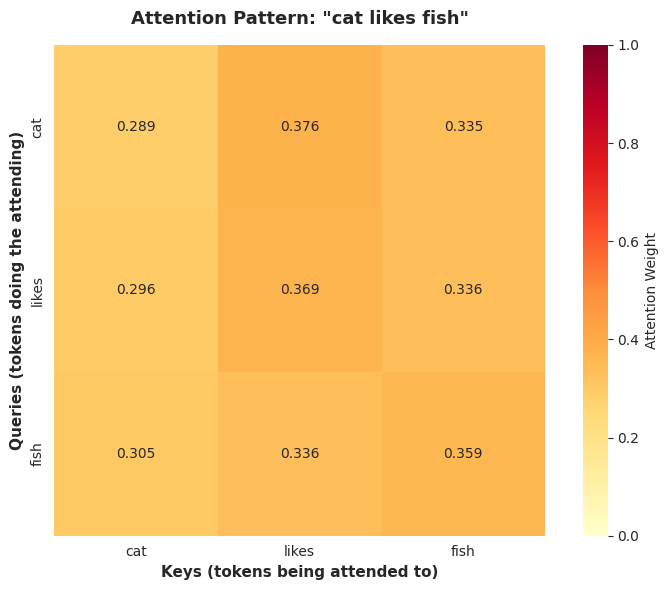


📊 How to read this heatmap:
   - Each ROW shows: 'Where does this word look?'
   - Each COLUMN shows: 'Who is looking at this word?'
   - Brighter colors = stronger attention

   Example: Row 2 ('likes') has fairly even attention across all words,
            meaning 'likes' gathers information from the entire sentence!


In [9]:
# Visualize attention weights as a heatmap
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    attention_weights, 
    annot=True, 
    fmt='.3f',
    xticklabels=words,
    yticklabels=words,
    cmap='YlOrRd',
    cbar_kws={'label': 'Attention Weight'},
    vmin=0,
    vmax=1,
    square=True,
    ax=ax
)

ax.set_xlabel('Keys (tokens being attended to)', fontsize=11, fontweight='bold')
ax.set_ylabel('Queries (tokens doing the attending)', fontsize=11, fontweight='bold')
ax.set_title('Attention Pattern: "cat likes fish"', fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

print("\n📊 How to read this heatmap:")
print("   - Each ROW shows: 'Where does this word look?'")
print("   - Each COLUMN shows: 'Who is looking at this word?'")
print("   - Brighter colors = stronger attention")
print("\n   Example: Row 2 ('likes') has fairly even attention across all words,")
print("            meaning 'likes' gathers information from the entire sentence!")

### The Big Picture: What Did We Just Do?

Let's summarize the **attention mechanism** we just walked through:

```markdown
Input Embeddings
      ↓
   ┌──┴──┬──────┐
   ↓     ↓      ↓      
   W_q   W_k    W_v    ← Three SEPARATE learned matrices
   ↓     ↓      ↓
   Q     K      V      ← Three INDEPENDENT vectors
   └──┬──┘      │
      ↓         │
   Q @ K.T      │      ← Q and K compute SCORES
      ↓         │
   Softmax      │
      ↓         │
   Weights ─────┘      ← Weights are applied to V
      ↓
   Output
```

**Key Insights:**

1. **Dynamic Attention**: Unlike fixed patterns, the model learns what to pay attention to based on the input
2. **Contextual Understanding**: Each word's output incorporates information from relevant words
3. **Differentiable**: All operations are differentiable, so we can train with backpropagation
4. **Parallelizable**: All attention computations happen simultaneously (not sequential like RNNs)

**What's Next?**

This was attention for a tiny 3-word example. In real transformers:
- Embeddings are 512-1024 dimensions (not just 4!)
- Sequences can be hundreds or thousands of tokens long
- We use **multiple attention heads** to capture different types of relationships
- We add **positional encodings** so the model knows word order

Let's see the formal mathematical definition next! 🎯

## 2. The Attention Formula

Now let's formalize what we learned into the canonical **scaled dot-product attention** function that powers all transformer models.

### The Mathematical Definition

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Where:
- **Q** (Query): Matrix of shape `(seq_len, d_k)` - "What am I looking for?"
- **K** (Key): Matrix of shape `(seq_len, d_k)` - "What do I offer?"
- **V** (Value): Matrix of shape `(seq_len, d_v)` - "Here's my information"
- **d_k**: Dimension of queries and keys (used for scaling)

### Breaking Down the Formula (Step by Step)

This formula performs 4 operations in sequence:

**Step 1: Compute Similarity Matrix** → $QK^T$
- Matrix multiply queries with transposed keys
- Result shape: `(seq_len, seq_len)` - attention score for every pair of positions
- Example: Position 3 attending to position 1 gets score at `[3, 1]`
   
**Step 2: Scale the Scores** → $\frac{QK^T}{\sqrt{d_k}}$
- Divide by square root of key dimension
- **Why?** When d_k is large (e.g., 512), dot products can become very large
- Large values → extreme softmax outputs (all weight on one position) → vanishing gradients
- Scaling keeps values in a reasonable range for stable training
   
**Step 3: Apply Softmax** → $\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)$
- Convert scores to probabilities: each row sums to 1.0
- Now each row represents: "How should this position distribute its attention?"
- High scores become high probabilities, low scores become near-zero
   
**Step 4: Weighted Sum of Values** → $\text{softmax}(...)V$
- Multiply attention weights by values matrix
- Each output vector is a **weighted mixture** of all value vectors
- Result shape: `(seq_len, d_v)` - contextualized representation for each position

Let's implement this as a reusable PyTorch function!

In [10]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Compute scaled dot-product attention.
    
    Args:
        Q: Query tensor of shape (batch_size, seq_len_q, d_k)
        K: Key tensor of shape (batch_size, seq_len_k, d_k)
        V: Value tensor of shape (batch_size, seq_len_v, d_v)
        mask: Optional mask tensor of shape (batch_size, seq_len_q, seq_len_k)
              where 0 indicates positions that should be masked out
    
    Returns:
        output: Attention output of shape (batch_size, seq_len_q, d_v)
        attention_weights: Attention weights of shape (batch_size, seq_len_q, seq_len_k)
    """
    # Get dimension for scaling
    d_k = Q.size(-1)
    
    # Step 1: Compute attention scores (Q @ K^T)
    # Shape: (batch_size, seq_len_q, seq_len_k)
    scores = torch.matmul(Q, K.transpose(-2, -1))
    
    # Step 2: Scale by sqrt(d_k)
    scores = scores / math.sqrt(d_k)
    
    # Apply mask if provided (set masked positions to -inf before softmax)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))
    
    # Step 3: Apply softmax to get attention weights
    attention_weights = F.softmax(scores, dim=-1)
    
    # Step 4: Compute weighted sum of values
    output = torch.matmul(attention_weights, V)
    
    return output, attention_weights

print("✅ Scaled dot-product attention function defined!")
print("\nThis is the EXACT attention mechanism used in:")
print("  - BERT, GPT, T5, LLaMA, Claude, ChatGPT, and every transformer model!")
print("  - The only difference is the dimensionality and how Q, K, V are computed")

✅ Scaled dot-product attention function defined!

This is the EXACT attention mechanism used in:
  - BERT, GPT, T5, LLaMA, Claude, ChatGPT, and every transformer model!
  - The only difference is the dimensionality and how Q, K, V are computed


### Verify Attention Properties

Let's verify that our attention weights have the correct properties:

In [11]:
# Create example input: batch of 1, sequence length 5, embedding dimension 8
batch_size = 1
seq_len = 5
d_model = 8

# 📝 Where do embeddings come from in real transformers?
# 
# Input Pipeline:
# 1. Tokenization: "The cat sat" → [101, 2543, 2068, 102] (token IDs)
# 2. Embedding Lookup: Each token ID → Dense vector from learned embedding matrix
#    - Embedding matrix shape: (vocab_size, d_model) e.g., (30000, 768)
#    - Each token gets its own learned vector representation
# 3. Positional Encoding: Add position information (we'll cover in Section 4!)
# 4. Linear Projections: Embeddings → Q, K, V via learned weight matrices W_Q, W_K, W_V
#
# For this demo, we use random embeddings to focus purely on the attention mechanism
torch.manual_seed(SEED)
embeddings = torch.randn(batch_size, seq_len, d_model)

# In self-attention, Q = K = V all come from the same source
# Real transformers compute: Q = XW_Q, K = XW_K, V = XW_V (learned linear transformations)
Q = embeddings
K = embeddings
V = embeddings

print(f"Input shape: {embeddings.shape}")
print(f"  Batch size: {batch_size}")
print(f"  Sequence length: {seq_len}")
print(f"  Embedding dimension: {d_model}")

# Apply attention
output, attn_weights = scaled_dot_product_attention(Q, K, V)

print(f"\nOutput shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")

print(f"\n✅ Shapes are correct!")
print(f"   Input:  (batch={batch_size}, seq_len={seq_len}, d_model={d_model})")
print(f"   Output: (batch={batch_size}, seq_len={seq_len}, d_model={d_model})")
print(f"   Weights: (batch={batch_size}, seq_len={seq_len}, seq_len={seq_len})")

Input shape: torch.Size([1, 5, 8])
  Batch size: 1
  Sequence length: 5
  Embedding dimension: 8

Output shape: torch.Size([1, 5, 8])
Attention weights shape: torch.Size([1, 5, 5])

✅ Shapes are correct!
   Input:  (batch=1, seq_len=5, d_model=8)
   Output: (batch=1, seq_len=5, d_model=8)
   Weights: (batch=1, seq_len=5, seq_len=5)


### Testing Our Attention Function

Let's test our implementation with a real example using PyTorch tensors. 

**Key concept:** Even with random embeddings, attention produces valid probability distributions and maintains the correct tensor dimensions throughout the computation.

**What we're testing:**

- Create a batch of embeddings (simulating a 5-word sentence)- Check that attention weights have the right mathematical properties

- Apply our attention function to see what patterns emerge- Verify that the output shapes are correct

Attention weights - row sums (should all be 1.0):
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000]])
✓ All rows sum to 1: True

✓ All weights non-negative: True
✓ All weights in [0,1]: True

📊 Attention weights matrix:
   (showing how much each position attends to every other position)



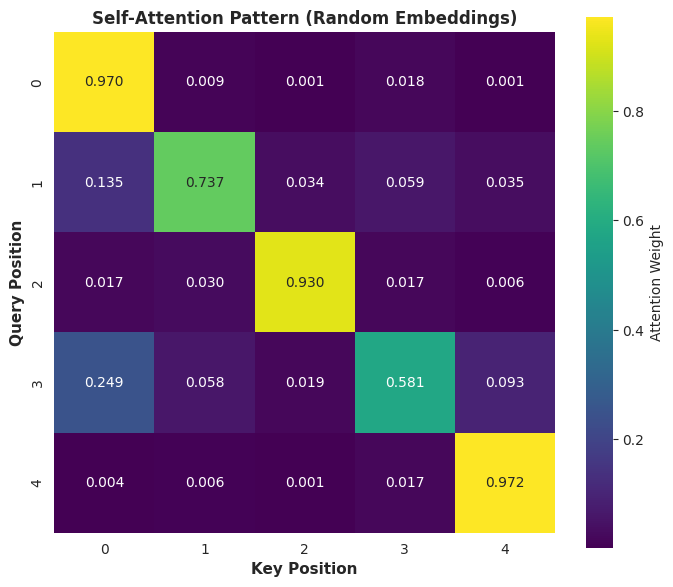

In [12]:
# Property 1: Each row should sum to 1 (probability distribution)
row_sums = attn_weights.sum(dim=-1)
print("Attention weights - row sums (should all be 1.0):")
print(row_sums)
print(f"✓ All rows sum to 1: {torch.allclose(row_sums, torch.ones_like(row_sums))}")

# Property 2: All weights should be non-negative (from softmax)
print(f"\n✓ All weights non-negative: {(attn_weights >= 0).all().item()}")

# Property 3: Weights should be between 0 and 1
print(f"✓ All weights in [0,1]: {((attn_weights >= 0) & (attn_weights <= 1)).all().item()}")

# Visualize the attention pattern
print("\n📊 Attention weights matrix:")
print("   (showing how much each position attends to every other position)\n")
attn_matrix = attn_weights[0].detach().numpy()  # Remove batch dimension

fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(
    attn_matrix,
    annot=True,
    fmt='.3f',
    cmap='viridis',
    square=True,
    cbar_kws={'label': 'Attention Weight'},
    ax=ax
)
ax.set_xlabel('Key Position', fontsize=11, fontweight='bold')
ax.set_ylabel('Query Position', fontsize=11, fontweight='bold')
ax.set_title('Self-Attention Pattern (Random Embeddings)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### Understanding Masking: Controlling What the Model Can "See"

In many scenarios, we need to **prevent attention to certain positions**.  
Masking is how we control which tokens can attend to which other tokens.  

**Two Main Types of Masking:**

1. **Padding Mask** (for variable-length sequences)
  - Problem: Batches contain sentences of different lengths → pad shorter ones with special `<PAD>` tokens
  - Solution: Mask prevents attention to padding positions
  - Example: `["The cat sat", "Hello"]` → `["The cat sat <PAD>", "Hello <PAD> <PAD>"]`
  - Mask ensures "Hello" doesn't waste attention on meaningless padding tokens

2. **Causal Mask** (for autoregressive generation)
  - Problem: When generating text, token at position `i` shouldn't see future tokens (positions > `i`)
  - Solution: Mask creates a **lower triangular** pattern - position `i` only sees positions ≤ `i`
  - This is how GPT generates: "The cat" → predict "sat" → "The cat sat" → predict next word
  - During training, we can process the whole sequence in parallel while enforcing this constraint!

#### How Masking Works Technically:

Before applying softmax, we set masked positions to `-inf`:
```python
scores = scores.masked_fill(mask == 0, float('-inf'))
```

When softmax is applied, `exp(-inf) = 0`, so masked positions get zero attention weight!

Let's visualize causal masking in action:

Causal Mask (1 = allowed, 0 = blocked):
[[1 0 0 0 0]
 [1 1 0 0 0]
 [1 1 1 0 0]
 [1 1 1 1 0]
 [1 1 1 1 1]]

Interpretation:
  - Row 0 (position 0): Can only see position 0 (itself)
  - Row 1 (position 1): Can see positions 0-1
  - Row 2 (position 2): Can see positions 0-2
  - etc. → Each position can only see past and present, not future!


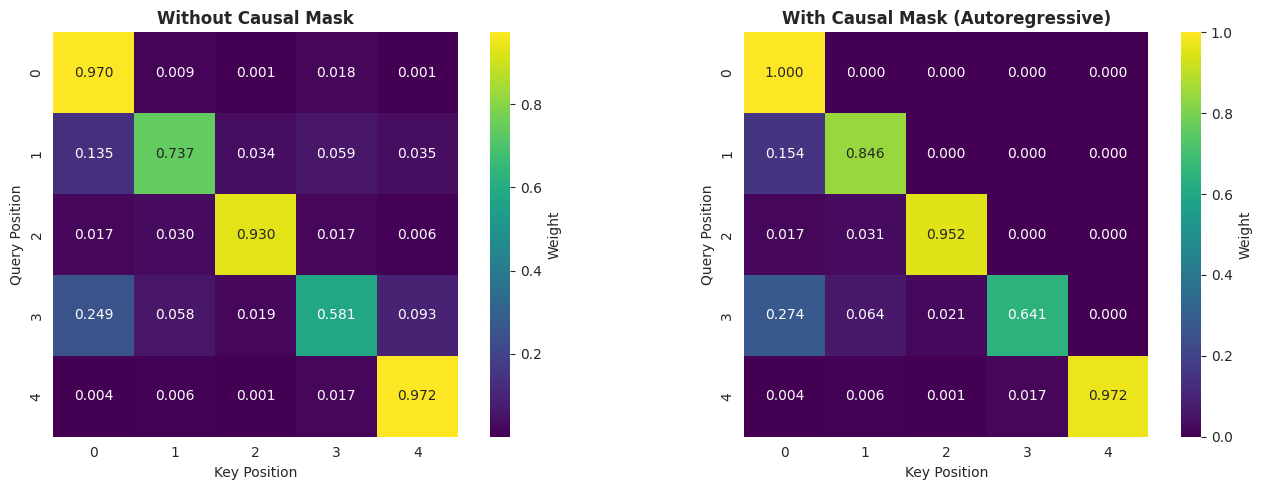


💡 Notice: With causal masking, upper triangle is all zeros!
   This is how GPT-style models generate text one token at a time.


In [13]:
# Create a causal mask using the helper function
# Position i can only attend to positions <= i (no looking ahead)
causal_mask = create_causal_mask(seq_len)

print("Causal Mask (1 = allowed, 0 = blocked):")
print(causal_mask.numpy().astype(int))

# Apply attention with causal mask
masked_output, masked_attn = scaled_dot_product_attention(
    Q, K, V, 
    mask=causal_mask.unsqueeze(0)  # Add batch dimension
)

# Visualize the effect of causal masking
visualize_causal_masking(attn_weights, masked_attn, seq_len)

### Key Takeaways

**What we've learned:**

1. ✅ **The Attention Formula**: `softmax(QK^T / √d_k)V` is universal across all transformers
2. ✅ **Implementation**: Built a working attention function in just ~15 lines of PyTorch
3. ✅ **Properties**: Attention weights are probabilities (sum to 1, non-negative)
4. ✅ **Masking**: Can control which positions attend to which (crucial for generation)

**Why this matters:**

- This SAME function is used in BERT (encoder), GPT (decoder), and T5 (both)
- The only differences are:
  - How Q, K, V are computed (linear projections we'll see next)
  - Whether masking is applied
  - How many attention heads are used (multi-head attention - coming up!)

**Next up:** Multi-head attention - running multiple attention operations in parallel to capture different types of relationships! 🚀

# 3. Multi-Head Attention

Now that we understand single-head attention, let's explore why transformers use **multiple attention heads** running in parallel.

### Why Multiple Heads?

Think back to our library analogy. Imagine searching for books about "neural networks":

**Single Head (One Librarian):**
- One person searches using one strategy
- Might focus only on exact title matches
- Could miss books with relevant content but different titles

**Multi-Head (Team of Librarians):**
- **Librarian 1**: Searches by exact keyword matches
- **Librarian 2**: Searches by topic similarity
- **Librarian 3**: Searches by author expertise
- **Librarian 4**: Searches by publication date and citations

Each librarian uses a different strategy, then they combine their findings for a richer result!

### Multi-Head Attention Does the Same!

Different attention heads learn to capture different types of relationships:

- **Head 1**: Syntactic relationships (subject-verb agreement)
- **Head 2**: Coreference (pronouns to their referents)
- **Head 3**: Semantic similarity (related concepts)
- **Head 4**: Long-range dependencies
- ... and more!

**The key insight:** The model learns these specializations automatically during training. We don't tell it what each head should do - it figures out what's useful!

### How It Works

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

where each head is:

$$\text{head}_i = \text{Attention}(QW^Q_i, KW^K_i, VW^V_i)$$

**Steps:**
1. **Project**: Transform Q, K, V into h different representations (one per head)
2. **Compute**: Run attention independently for each head
3. **Concatenate**: Combine all head outputs
4. **Project**: Transform concatenated output back to original dimension

Let's implement this!

In [14]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention mechanism.
    
    Instead of one attention function, we run h attention operations in parallel,
    each with different learned linear projections. This allows the model to
    attend to information from different representation subspaces.
    """
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head
        
        # Linear projections for Q, K, V (for ALL heads combined)
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        # Output projection
        self.W_o = nn.Linear(d_model, d_model)
        
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (num_heads, d_k).
        Transpose to shape: (batch_size, num_heads, seq_len, d_k)
        """
        x = x.view(batch_size, -1, self.num_heads, self.d_k)
        return x.transpose(1, 2)
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # 1. Linear projections
        Q = self.W_q(query)  # (batch_size, seq_len, d_model)
        K = self.W_k(key)
        V = self.W_v(value)
        
        # 2. Split into multiple heads
        Q = self.split_heads(Q, batch_size)  # (batch_size, num_heads, seq_len, d_k)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)
        
        # 3. Apply attention for each head
        if mask is not None:
            # Same mask applied to all heads
            mask = mask.unsqueeze(1)
        
        attn_output, attn_weights = scaled_dot_product_attention(Q, K, V, mask)
        # attn_output shape: (batch_size, num_heads, seq_len, d_k)
        
        # 4. Concatenate heads
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.view(batch_size, -1, self.d_model)
        
        # 5. Final linear projection
        output = self.W_o(attn_output)
        
        return output, attn_weights

# Test multi-head attention
d_model = 512
num_heads = 8
seq_len = 10
batch_size = 2

# Create multi-head attention layer
mha = MultiHeadAttention(d_model, num_heads)

# Create sample input
torch.manual_seed(SEED)
x = torch.randn(batch_size, seq_len, d_model)

# Apply multi-head attention (self-attention: Q=K=V=x)
output, attention_weights = mha(x, x, x)

print("Multi-Head Attention Test:")
print(f"  Input shape: {x.shape}")
print(f"  Output shape: {output.shape}")
print(f"  Number of heads: {num_heads}")
print(f"  Dimension per head: {d_model // num_heads}")
print(f"  Attention weights shape: {attention_weights.shape}")
print(f"\n✅ Multi-head attention working correctly!")
print(f"   Each of the {num_heads} heads processes {d_model // num_heads}-dimensional representations")

Multi-Head Attention Test:
  Input shape: torch.Size([2, 10, 512])
  Output shape: torch.Size([2, 10, 512])
  Number of heads: 8
  Dimension per head: 64
  Attention weights shape: torch.Size([2, 8, 10, 10])

✅ Multi-head attention working correctly!
   Each of the 8 heads processes 64-dimensional representations


### Visualizing Different Attention Heads

Let's see what different heads actually learn by using a pretrained BERT model. We'll look at how different heads attend to the same sentence.

**Note:** BERT has 12 layers, each with 12 attention heads = 144 heads total! Each learns different patterns.

In [15]:
# Load pretrained BERT with attention outputs
from transformers import BertTokenizer, BertModel

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_attentions=True)
model.eval()

# Prepare a sentence
sentence = "The cat sat on the mat because it was comfortable"
print(f"Analyzing: '{sentence}'\n")

# Tokenize
inputs = tokenizer(sentence, return_tensors='pt')
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

print(f"Tokens: {tokens}")
print(f"Number of tokens: {len(tokens)}\n")

# Get model outputs with attention
with torch.no_grad():
    outputs = model(**inputs)
    attentions = outputs.attentions  # Tuple of (num_layers, batch, num_heads, seq_len, seq_len)

print(f"BERT Architecture:")
print(f"  Layers: {len(attentions)}")
print(f"  Heads per layer: {attentions[0].shape[1]}")
print(f"  Attention matrix shape per head: {attentions[0].shape[2:4]}")
print(f"\n  Total attention heads: {len(attentions) * attentions[0].shape[1]}")

Analyzing: 'The cat sat on the mat because it was comfortable'

Tokens: ['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', 'because', 'it', 'was', 'comfortable', '[SEP]']
Number of tokens: 12

BERT Architecture:
  Layers: 12
  Heads per layer: 12
  Attention matrix shape per head: torch.Size([12, 12])

  Total attention heads: 144


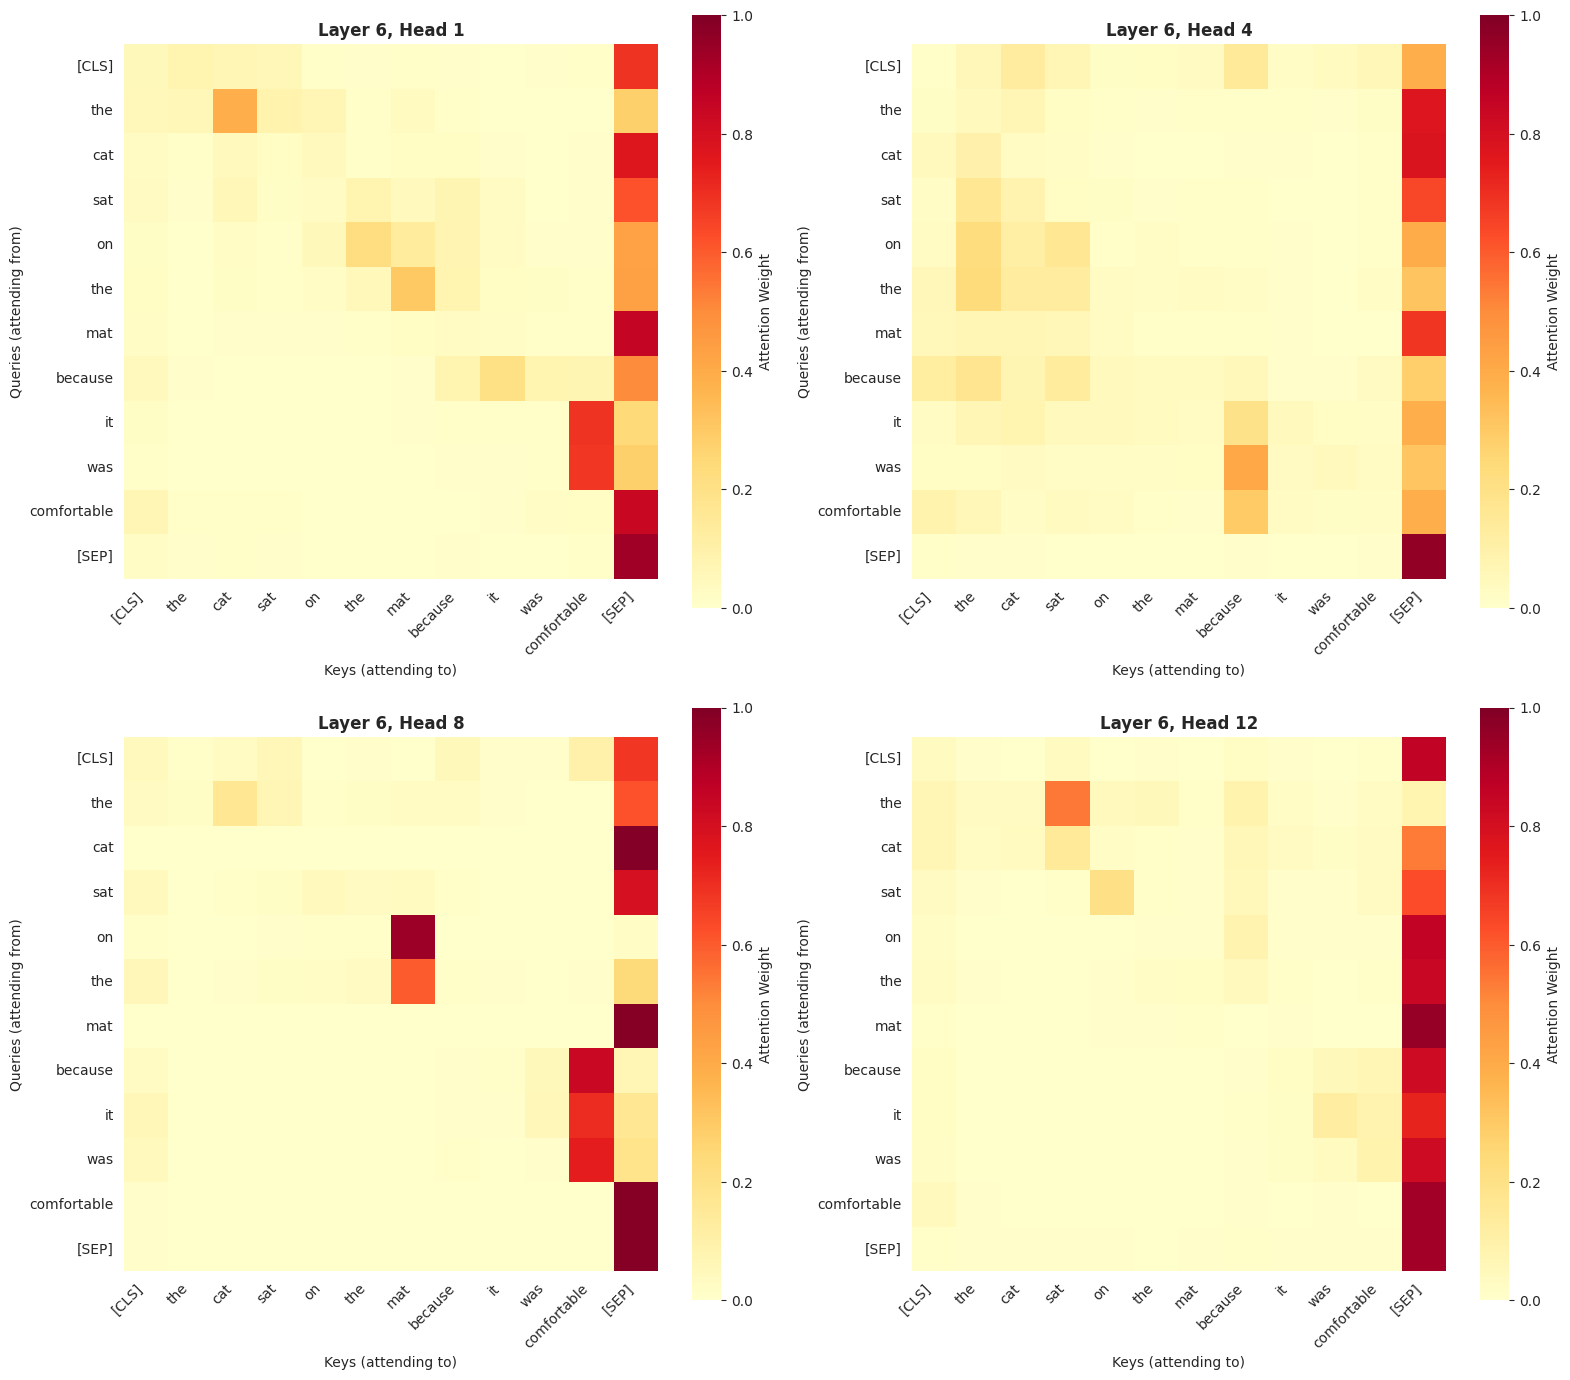


🔍 Notice how different heads focus on different patterns:
   - Some heads may focus on nearby words (local context)
   - Others may focus on specific tokens like [CLS] or punctuation
   - Some may show coreference patterns (connecting 'it' to 'mat' or 'cat')
   - Different heads learn complementary patterns automatically!


In [16]:
# Visualize attention patterns from different heads in the same layer
layer_to_visualize = 5  # Middle layer (0-indexed)
heads_to_show = [0, 3, 7, 11]  # Show 4 different heads

# Use the function
visualize_attention_heads(attentions, layer_to_visualize, heads_to_show, tokens)

### Analyzing Coreference: What does "it" attend to?

Let's zoom in on the pronoun "it" and see which heads connect it to its referent ("mat" or "cat").

In [17]:
# Find the position of "it" in the tokens
it_pos = tokens.index('it')
print(f"Position of 'it': {it_pos}")
print(f"Tokens: {tokens}\n")

# Analyze attention from "it" across all layers and heads
# We'll see which words "it" pays most attention to

print("Top 3 words that 'it' attends to (across different layers):\n")

for layer_idx in [0, 5, 11]:  # Early, middle, late layers
    print(f"Layer {layer_idx + 1}:")
    
    # Average attention across all heads in this layer
    layer_attn = attentions[layer_idx][0]  # (num_heads, seq_len, seq_len)
    avg_attn = layer_attn.mean(dim=0)  # Average over heads: (seq_len, seq_len)
    
    # Get attention from "it" to all other tokens
    it_attention = avg_attn[it_pos].detach().numpy()
    
    # Get top 3 attended tokens (excluding special tokens and itself)
    top_indices = np.argsort(it_attention)[::-1]
    
    count = 0
    for idx in top_indices:
        token = tokens[idx]
        weight = it_attention[idx]
        
        # Skip special tokens and the word itself
        if token not in ['[CLS]', '[SEP]', '[PAD]', 'it'] and count < 3:
            print(f"  {token:12s} → {weight:.3f}")
            count += 1
    print()

print("💡 Observation:")
print("   - Early layers often focus on nearby words and syntax")
print("   - Middle layers start capturing semantic relationships")
print("   - Later layers refine task-specific patterns")
print("   - Different layers solve different sub-problems!")

Position of 'it': 8
Tokens: ['[CLS]', 'the', 'cat', 'sat', 'on', 'the', 'mat', 'because', 'it', 'was', 'comfortable', '[SEP]']

Top 3 words that 'it' attends to (across different layers):

Layer 1:
  because      → 0.203
  comfortable  → 0.145
  was          → 0.092

Layer 6:
  comfortable  → 0.173
  because      → 0.095
  was          → 0.088

Layer 12:
  on           → 0.038
  sat          → 0.034
  cat          → 0.030

💡 Observation:
   - Early layers often focus on nearby words and syntax
   - Middle layers start capturing semantic relationships
   - Later layers refine task-specific patterns
   - Different layers solve different sub-problems!


### Key Takeaways: Multi-Head Attention

**What we've learned:**

1. ✅ **Multiple Perspectives**: Each head learns to focus on different aspects of relationships
   - Syntax, semantics, coreference, position, etc.
   
2. ✅ **Parallel Processing**: All heads compute simultaneously
   - Much faster than sequential processing
   - Each head works with smaller dimensions (d_model / num_heads)

3. ✅ **Automatic Specialization**: We don't specify what each head should learn
   - The model figures out useful patterns through training
   - Different heads naturally specialize in complementary ways

4. ✅ **Richer Representations**: Combining multiple heads captures more information
   - Single head: One way to relate words
   - Multi-head: Multiple complementary relationships

**The Power of Ensemble:**

Think of multi-head attention like having multiple experts on a panel:
- Each expert (head) has their own specialty
- They all analyze the same input independently
- Their insights are combined for a richer understanding
- No single expert has to be perfect - they complement each other!

**Next up:** Understanding positional encoding - how transformers know word order! 📍

# 4. Positional Encoding

So far we've learned how attention allows words to "look at" each other. But there's a critical problem we haven't addressed yet...

### The Problem: Attention is Order-Agnostic!

Consider these two sentences:
- "The **cat** chased the **dog**"
- "The **dog** chased the **cat**"

These have **completely different meanings**, but if we only use attention without position information, the model would treat them identically!

**Why?** Attention computes:
- Similarity scores between all pairs of words
- Weighted combinations based on content

But it doesn't inherently know which word came first!

Let's demonstrate this with a concrete example:

In [18]:
# Demonstrate that attention is order-agnostic
# Create embeddings for "cat" and "dog"
torch.manual_seed(SEED)
cat_embedding = torch.randn(1, 1, 8)
dog_embedding = torch.randn(1, 1, 8)

# Sentence 1: "cat dog" (cat then dog)
sentence1 = torch.cat([cat_embedding, dog_embedding], dim=1)

# Sentence 2: "dog cat" (dog then cat) - SAME EMBEDDINGS, different order
sentence2 = torch.cat([dog_embedding, cat_embedding], dim=1)

# Set print options for clean display (both numpy and torch)
np.set_printoptions(linewidth=200, suppress=True)
torch.set_printoptions(linewidth=200, sci_mode=False)

print("Sentence 1 (cat dog):")
print(sentence1)

print("\nSentence 2 (dog cat):")
print(sentence2)

# Apply self-attention to both (Q=K=V)
_, attn1 = scaled_dot_product_attention(sentence1, sentence1, sentence1)
_, attn2 = scaled_dot_product_attention(sentence2, sentence2, sentence2)

print("\n" + "="*60)
print("ATTENTION WEIGHTS")
print("="*60)

print("\nSentence 1 'cat dog' - Attention pattern:")
print(attn1[0].detach().numpy())

print("\nSentence 2 'dog cat' - Attention pattern:")
print(attn2[0].detach().numpy())

# Check if patterns are the same (just permuted)
print("\n💡 Notice:")
print("   The attention patterns are permutations of each other!")
print("   Position 0→1 in sentence1 has same weight as position 1→0 in sentence2")
print("   This is because attention only looks at CONTENT, not POSITION!")
print("\n   Without positional information, these sentences are indistinguishable! 🚨")

Sentence 1 (cat dog):
tensor([[[ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863,  2.2082, -0.6380],
         [ 0.4617,  0.2674,  0.5349,  0.8094,  1.1103, -1.6898, -0.9890,  0.9580]]])

Sentence 2 (dog cat):
tensor([[[ 0.4617,  0.2674,  0.5349,  0.8094,  1.1103, -1.6898, -0.9890,  0.9580],
         [ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863,  2.2082, -0.6380]]])

ATTENTION WEIGHTS

Sentence 1 'cat dog' - Attention pattern:
[[0.9720862  0.02791378]
 [0.02438089 0.9756191 ]]

Sentence 2 'dog cat' - Attention pattern:
[[0.9756191  0.02438089]
 [0.02791378 0.9720862 ]]

💡 Notice:
   The attention patterns are permutations of each other!
   Position 0→1 in sentence1 has same weight as position 1→0 in sentence2
   This is because attention only looks at CONTENT, not POSITION!

   Without positional information, these sentences are indistinguishable! 🚨


### The Solution: Positional Encoding

We need to inject position information into our embeddings. The solution is surprisingly simple:

**Add a unique "position vector" to each word's embedding!**

```
Final Embedding = Word Embedding + Position Encoding
```

**How do we create these position vectors?**

Most modern models (BERT, GPT) use **learned positional embeddings**:
- Just a lookup table: position 0 → learned vector, position 1 → learned vector, etc.
- These vectors are learned during training (like word embeddings)
- Simple and effective!

The original Transformer paper (2017) used **sinusoidal encoding** (sine/cosine functions), which also works but is less common today.

Let's see how this fixes our cat/dog problem:

In [19]:
# Simple demonstration: add position information to solve the order problem
torch.manual_seed(SEED)

# Create word embeddings (same as before)
cat_embed = torch.randn(1, 8)
dog_embed = torch.randn(1, 8)

# Create simple position encodings (in practice, these are learned or sinusoidal)
# For this demo, we'll use simple random vectors to represent positions
position_0 = torch.tensor([[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]])
position_1 = torch.tensor([[0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]])

print("="*70)
print("ADDING POSITIONAL ENCODING")
print("="*70)

print("\n📌 Sentence 1: 'cat dog'")
print("-" * 70)
cat_at_pos0 = cat_embed + position_0
dog_at_pos1 = dog_embed + position_1

print(f"Cat at position 0 = cat_embedding + position_0")
print(f"  Result (first 8 dims): {cat_at_pos0[0].numpy()}")

print(f"\nDog at position 1 = dog_embedding + position_1")
print(f"  Result (first 8 dims): {dog_at_pos1[0].numpy()}")

print("\n" + "="*70)
print("📌 Sentence 2: 'dog cat' (SWAPPED)")
print("-" * 70)
dog_at_pos0 = dog_embed + position_0
cat_at_pos1 = cat_embed + position_1

print(f"Dog at position 0 = dog_embedding + position_0")
print(f"  Result (first 8 dims): {dog_at_pos0[0].numpy()}")

print(f"\nCat at position 1 = cat_embedding + position_1")
print(f"  Result (first 8 dims): {cat_at_pos1[0].numpy()}")

print("\n" + "="*70)
print("💡 KEY INSIGHT")
print("="*70)
print("✓ 'cat' at position 0 ≠ 'cat' at position 1 (different position encodings)")
print("✓ 'dog' at position 0 ≠ 'dog' at position 1 (different position encodings)")
print("✓ Now 'cat dog' and 'dog cat' have DIFFERENT representations!")
print("✓ The model can now distinguish word order! 🎯")
print("="*70)

ADDING POSITIONAL ENCODING

📌 Sentence 1: 'cat dog'
----------------------------------------------------------------------
Cat at position 0 = cat_embedding + position_0
  Result (first 8 dims): [ 1.3366904   0.1288094   1.2344624   0.23033303 -0.12285638 -0.18632829  3.2082014  -0.63799703]

Dog at position 1 = dog_embedding + position_1
  Result (first 8 dims): [ 0.46165723  1.2673509   0.53490466  1.8093572   1.1102903  -0.68979895 -0.9889599   1.9579718 ]

📌 Sentence 2: 'dog cat' (SWAPPED)
----------------------------------------------------------------------
Dog at position 0 = dog_embedding + position_0
  Result (first 8 dims): [ 1.4616573   0.26735088  1.5349047   0.8093572   2.1102903  -1.689799    0.01104009  0.9579718 ]

Cat at position 1 = cat_embedding + position_1
  Result (first 8 dims): [ 0.33669037  1.1288095   0.23446237  1.2303331  -1.1228564   0.8136717   2.2082014   0.36200297]

💡 KEY INSIGHT
✓ 'cat' at position 0 ≠ 'cat' at position 1 (different position encodings)

### How Positional Encoding Works in Practice

In real transformer models, positional encoding is added right at the input:

```python
# In PyTorch (simplified):
class TransformerInput(nn.Module):
    def __init__(self, vocab_size, d_model, max_seq_len):
        # Word embeddings (learned lookup table)
        self.word_embedding = nn.Embedding(vocab_size, d_model)
        
        # Position embeddings (also learned!)
        self.position_embedding = nn.Embedding(max_seq_len, d_model)
    
    def forward(self, token_ids):
        # Get word embeddings
        word_embeds = self.word_embedding(token_ids)
        
        # Get position embeddings
        positions = torch.arange(len(token_ids))
        pos_embeds = self.position_embedding(positions)
        
        # Add them together!
        return word_embeds + pos_embeds
```

That's it! Just **add position vectors to word vectors** before feeding them into the attention layers.

### Key Takeaways: Positional Encoding

**What we've learned:**

1. ✅ **The Problem**: Attention is order-agnostic
   - Without position info: "cat chased dog" = "dog chased cat"
   - The model can't distinguish word order by itself

2. ✅ **The Solution**: Add position encodings to embeddings
   - Most modern models use learned position embeddings (like BERT, GPT)
   - Original Transformer used sinusoidal functions (less common now)
   - Simple formula: `final_embedding = word_embedding + position_encoding`

3. ✅ **Why It Works**:
   - Each position gets its own unique vector
   - Same word at different positions → different final representations
   - Now the model can tell "cat dog" from "dog cat"!

**The Pipeline So Far:**

```
1. Tokenize: "The cat sat" → [101, 2543, 2068]
2. Word Embeddings: token IDs → vectors
3. Position Encodings: add position info
4. Multi-Head Attention: compute relationships
5. Output: contextualized representations
```

**Next up:** Assembling the complete Transformer architecture! 🚀

# 5️. Transformer Building Blocks

Now that we understand attention and positional encoding, let's see how these pieces fit together in the actual **Transformer architecture**.

A Transformer consists of **encoder blocks** and **decoder blocks**. We'll focus on the encoder here, which is used in models like BERT.

### The Encoder Block

Each encoder block has **4 main components**:

1. **Multi-Head Attention** - Words attend to each other
2. **Add & Normalize** - Residual connection + layer normalization
3. **Feed-Forward Network** - Two linear layers with activation
4. **Add & Normalize** - Another residual connection + layer normalization

**Why Residual Connections?**
- Allow gradients to flow directly through the network
- Help train very deep models (like 24+ layers in BERT-Large)

**Why Layer Normalization?**
- Stabilizes training by normalizing activations
- Makes the model less sensitive to initialization

In [20]:
# Let's build a simple encoder block using PyTorch's built-in components
import torch.nn as nn

# Configuration
d_model = 512      # Embedding dimension
num_heads = 8      # Number of attention heads
d_ff = 2048        # Feed-forward dimension (usually 4x d_model)
dropout = 0.1

# Create an encoder layer
encoder_layer = nn.TransformerEncoderLayer(
    d_model=d_model,
    nhead=num_heads,
    dim_feedforward=d_ff,
    dropout=dropout,
    batch_first=True  # Input shape: (batch, sequence, features)
)

print("Encoder Layer Components:")
print(encoder_layer)
print("\n" + "="*60)

# Let's trace what happens inside with a simple example
batch_size = 2
seq_len = 10
x = torch.randn(batch_size, seq_len, d_model)

print(f"\nInput shape: {x.shape}")
print(f"  (batch_size={batch_size}, sequence_length={seq_len}, d_model={d_model})")

# Pass through encoder layer
output = encoder_layer(x)

print(f"\nOutput shape: {output.shape}")
print("  ✓ Shape is preserved!")
print(f"\n  The encoder transforms the input but keeps the same dimensions.")
print(f"  This allows stacking multiple layers easily.")

Encoder Layer Components:
TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (linear1): Linear(in_features=512, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=512, bias=True)
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)


Input shape: torch.Size([2, 10, 512])
  (batch_size=2, sequence_length=10, d_model=512)

Output shape: torch.Size([2, 10, 512])
  ✓ Shape is preserved!

  The encoder transforms the input but keeps the same dimensions.
  This allows stacking multiple layers easily.


### Stacking Multiple Encoder Layers

In practice, transformers stack **multiple encoder layers** (6 in the original paper, 12 in BERT-Base, 24 in BERT-Large).

Each layer can learn different patterns:
- **Early layers**: Syntax, grammar, basic structure
- **Middle layers**: Semantic relationships, entity recognition
- **Late layers**: Task-specific abstractions

In [21]:
# Stack 6 encoder layers to create a full encoder
num_layers = 6

encoder = nn.TransformerEncoder(
    encoder_layer=encoder_layer,
    num_layers=num_layers
)

print(f"Full Encoder with {num_layers} layers:")
print(f"  Total parameters: {sum(p.numel() for p in encoder.parameters()):,}")
print("\n" + "="*60)

# Process input through all 6 layers
x = torch.randn(batch_size, seq_len, d_model)
print(f"\nInput shape:  {x.shape}")

output = encoder(x)
print(f"Output shape: {output.shape}")
print("\n  Each token has been processed through:")
print("    • 6 multi-head attention layers")
print("    • 6 feed-forward networks")
print("    • 12 residual connections")
print("    • 12 layer normalizations")
print("\n  Yet the shape remains (batch_size, seq_len, d_model)!")

Full Encoder with 6 layers:
  Total parameters: 18,914,304


Input shape:  torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])

  Each token has been processed through:
    • 6 multi-head attention layers
    • 6 feed-forward networks
    • 12 residual connections
    • 12 layer normalizations

  Yet the shape remains (batch_size, seq_len, d_model)!


### The Decoder Block

The decoder is used in **generative models** (like GPT) and has two key differences from the encoder:

1. **Masked Self-Attention** - Prevents tokens from "seeing" future tokens
   - During generation, the model can only look at previous words
   - Essential for autoregressive text generation

2. **Cross-Attention** (in encoder-decoder models like T5)
   - Decoder attends to encoder outputs
   - Used in translation, summarization, etc.

Let's see how masking works:

In [22]:
# Causal (autoregressive) masking for decoder
seq_len = 5

# Create a causal mask: upper triangular matrix of True values
# True means "mask out" (can't attend to)
causal_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()

print("Causal Mask (True = masked, can't attend):")
print(causal_mask.int())  # Convert to int for readability
print("\nInterpretation:")
print("  Token 0 can attend to: [0]         (only itself)")
print("  Token 1 can attend to: [0, 1]      (itself + past)")
print("  Token 2 can attend to: [0, 1, 2]   (itself + past)")
print("  Token 3 can attend to: [0, 1, 2, 3]")
print("  Token 4 can attend to: [0, 1, 2, 3, 4]")
print("\nThis ensures the model can't 'cheat' by looking at future tokens!")

# Let's use PyTorch's decoder layer
decoder_layer = nn.TransformerDecoderLayer(
    d_model=d_model,
    nhead=num_heads,
    dim_feedforward=d_ff,
    dropout=dropout,
    batch_first=True
)

print("\n" + "="*60)
print("Decoder Layer Components:")
print(decoder_layer)

Causal Mask (True = masked, can't attend):
tensor([[0, 1, 1, 1, 1],
        [0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

Interpretation:
  Token 0 can attend to: [0]         (only itself)
  Token 1 can attend to: [0, 1]      (itself + past)
  Token 2 can attend to: [0, 1, 2]   (itself + past)
  Token 3 can attend to: [0, 1, 2, 3]
  Token 4 can attend to: [0, 1, 2, 3, 4]

This ensures the model can't 'cheat' by looking at future tokens!

Decoder Layer Components:
TransformerDecoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (linear1): Linear(in_features=512, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=512, bia

### Putting It All Together: Three Architectures

Now we understand the building blocks! Here's how they're combined in different models:

**1. Encoder-Only (BERT, RoBERTa)**
- Stacked encoder layers
- Bidirectional attention (can see all tokens)
- Best for: Classification, Named Entity Recognition, Question Answering

**2. Decoder-Only (GPT, GPT-2, GPT-3, GPT-4)**
- Stacked decoder layers with causal masking
- Unidirectional attention (only sees past tokens)
- Best for: Text generation, completion, chatbots

**3. Encoder-Decoder (T5, BART, Transformer-original)**
- Encoder processes input → Decoder generates output
- Cross-attention connects them
- Best for: Translation, summarization, text-to-text tasks

In the next section, we'll use pretrained versions of these architectures!

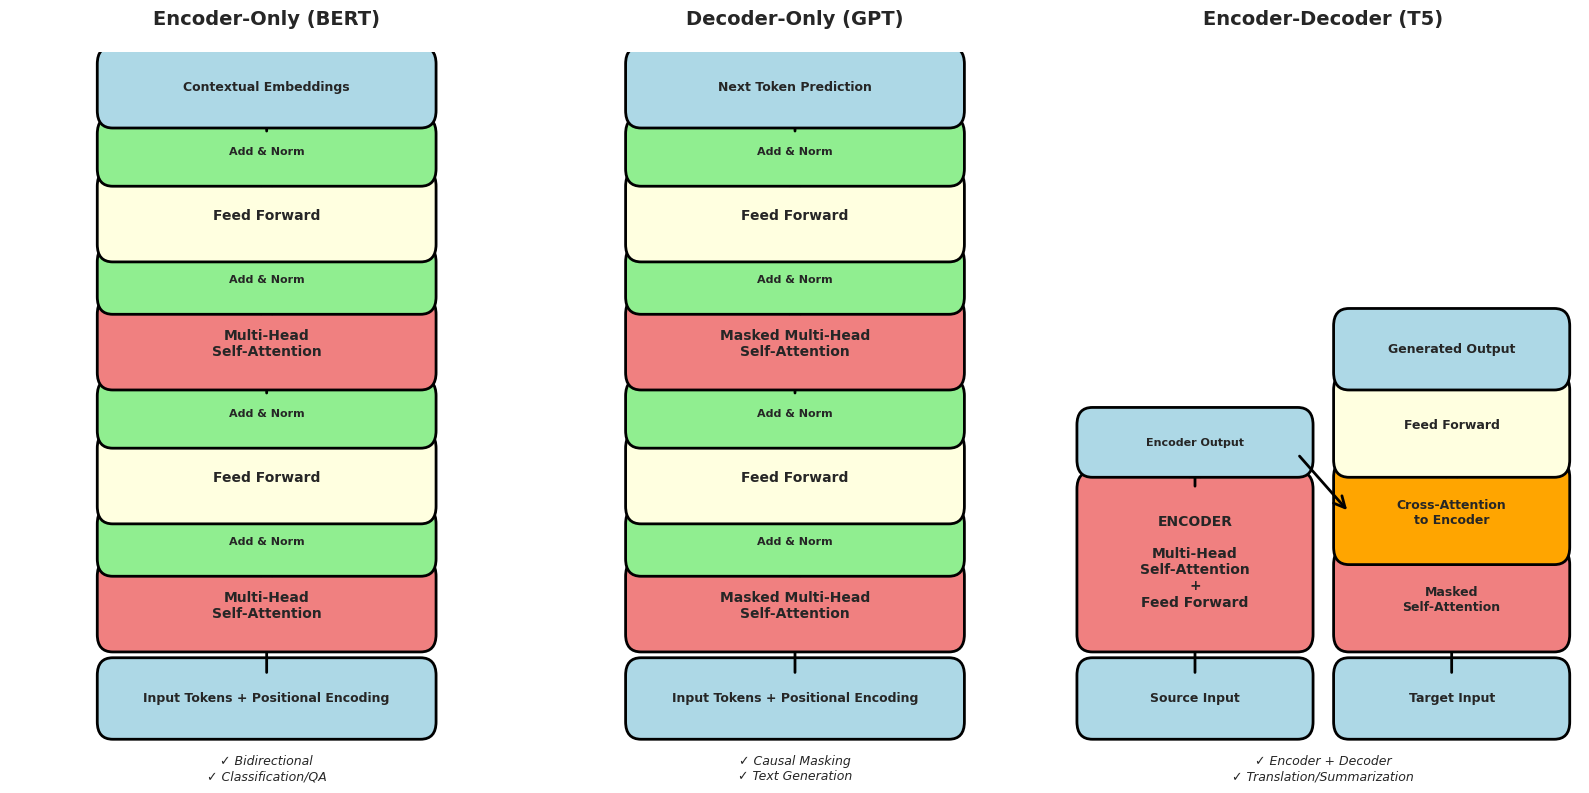


Key Differences:
• ENCODER-ONLY: Processes all tokens bidirectionally
                → Good for understanding tasks

• DECODER-ONLY: Masked attention, sees only past tokens
                → Good for generation tasks

• ENCODER-DECODER: Encoder understands, decoder generates
                   → Good for transformation tasks


In [23]:
plot_transformer_architectures()

# 6. Using Pretrained Models

Now that we understand how transformers work internally, let's learn how to **use them in practice**!

Thanks to the 🤗 Hugging Face library, we can use state-of-the-art pretrained models with just a few lines of code. No need to train from scratch - we can leverage models trained on massive datasets.

### Three Common Architectures

**1. Encoder-Only (BERT)**
- **Architecture**: Bidirectional encoder (sees entire input)
- **Best for**: Understanding tasks - classification, NER, question answering
- **Examples**: BERT, RoBERTa, DistilBERT, ALBERT

**2. Decoder-Only (GPT)**
- **Architecture**: Unidirectional decoder (causal masking)
- **Best for**: Generation tasks - text completion, creative writing
- **Examples**: GPT-2, GPT-3, GPT-4, LLaMA, Mistral

**3. Encoder-Decoder (T5)**
- **Architecture**: Both encoder and decoder
- **Best for**: Transformation tasks - translation, summarization
- **Examples**: T5, BART, mT5, Marian

Let's try each one!

### Example 1: Sentiment Analysis (BERT)

BERT is perfect for classification tasks. Let's use it to classify the sentiment of movie reviews.

In [24]:
# Load sentiment analysis pipeline (uses BERT-based model)
print("Loading sentiment analysis model...")
classifier = pipeline("sentiment-analysis")

# Test on various sentences
test_sentences = [
    "This movie was absolutely fantastic! Best film I've seen this year.",
    "I hated every minute of it. Complete waste of time.",
    "The movie was okay, nothing special.",
    "Mind-blowing cinematography and incredible acting!",
    "Boring and predictable. I fell asleep halfway through."
]

print("\n" + "="*70)
print("SENTIMENT ANALYSIS RESULTS")
print("="*70)

for sentence in test_sentences:
    result = classifier(sentence)[0]
    label = result['label']
    score = result['score']
    
    # Add emoji based on sentiment
    emoji = "😊" if label == "POSITIVE" else "😞"
    
    print(f"\n{emoji} Text: \"{sentence}\"")
    print(f"   Prediction: {label} (confidence: {score:.2%})")

print("\n" + "="*70)
print("💡 How it works:")
print("   1. Text → Tokenization → Token IDs")
print("   2. BERT encoder processes with bidirectional attention")
print("   3. [CLS] token representation → Classification head")
print("   4. Output: POSITIVE or NEGATIVE + confidence score")
print("="*70)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Loading sentiment analysis model...


Device set to use cpu



SENTIMENT ANALYSIS RESULTS

😊 Text: "This movie was absolutely fantastic! Best film I've seen this year."
   Prediction: POSITIVE (confidence: 99.99%)

😞 Text: "I hated every minute of it. Complete waste of time."
   Prediction: NEGATIVE (confidence: 99.98%)

😞 Text: "The movie was okay, nothing special."
   Prediction: NEGATIVE (confidence: 99.25%)

😊 Text: "Mind-blowing cinematography and incredible acting!"
   Prediction: POSITIVE (confidence: 99.99%)

😞 Text: "Boring and predictable. I fell asleep halfway through."
   Prediction: NEGATIVE (confidence: 99.98%)

💡 How it works:
   1. Text → Tokenization → Token IDs
   2. BERT encoder processes with bidirectional attention
   3. [CLS] token representation → Classification head
   4. Output: POSITIVE or NEGATIVE + confidence score


### Example 2: Text Generation (GPT-2)

GPT models are autoregressive - they predict the next word based on previous words. Let's see how text generation works and explore the **temperature** parameter.

In [25]:
# Load text generation pipeline
print("Loading GPT-2 model...")
generator = pipeline("text-generation", model="gpt2")

# Test prompts
prompts = [
    "Transformers are revolutionizing AI because",
    "The future of machine learning will",
    "Once upon a time, in a land of neural networks,"
]

print("\n" + "="*70)
print("TEXT GENERATION WITH DIFFERENT TEMPERATURES")
print("="*70)

for prompt in prompts[:2]:  # Use first 2 prompts
    print(f"\n🎯 Prompt: \"{prompt}\"")
    print("-" * 70)
    
    # Temperature controls randomness:
    # - Low (0.1-0.5): Focused, predictable, repetitive
    # - Medium (0.7-1.0): Balanced creativity
    # - High (1.5+): Very creative, sometimes nonsensical
    
    for temp in [0.3, 0.8, 1.2]:
        result = generator(
            prompt,
            max_length=40,
            num_return_sequences=1,
            temperature=temp,
            do_sample=True,
            pad_token_id=50256  # GPT-2's EOS token
        )[0]['generated_text']
        
        # Extract only the generated part (after prompt)
        generated = result[len(prompt):].strip()
        
        print(f"\n  Temperature {temp}:")
        print(f"  → {generated}")

print("\n" + "="*70)
print("💡 Understanding Temperature:")
print("   • Low (0.3): Conservative, picks most likely words → coherent but boring")
print("   • Medium (0.8): Balanced creativity → good for most tasks")
print("   • High (1.2): More random → creative but can be incoherent")
print("\n   The model uses causal masking: only sees previous words!")
print("="*70)

Loading GPT-2 model...


Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



TEXT GENERATION WITH DIFFERENT TEMPERATURES

🎯 Prompt: "Transformers are revolutionizing AI because"
----------------------------------------------------------------------


Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



  Temperature 0.3:
  → they are able to do things that humans cannot.

The AI revolution is happening in the real world. In the real world, robots are being used to do things that humans cannot.

The AI revolution is happening in the real world. In the real world, robots are being used to do things that humans cannot.

The AI revolution is happening in the real world. In the real world, robots are being used to do things that humans cannot.

The AI revolution is happening in the real world. In the real world, robots are being used to do things that humans cannot.

The AI revolution is happening in the real world. In the real world, robots are being used to do things that humans cannot.

The AI revolution is happening in the real world. In the real world, robots are being used to do things that humans cannot.

The AI revolution is happening in the real world. In the real world, robots are being used to do things that humans cannot.

The AI revolution is happening in the real world. In 

Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



  Temperature 0.8:
  → it is an efficient way to learn human behavior. More specifically, they are transforming the way scientists study the behavior of animals. In essence, they are changing the way people think about how a person behaves and the behavior they engage in.

In a 2013 interview published in PLoS ONE, the co-author, Richard W. Stapleton, a neuroscientist at Johns Hopkins University and a pioneer of AI, said that the next great breakthrough in AI is going to take a lot of effort.

"I think a lot of the work is going to come out of the field in the next few years," Stapleton told Science in 2010, and he is planning to keep going. "In the meantime, we'll continue our work on AI in high performance and high cost at large by building on the ideas that we already have in the field of machine learning.

"Even when we don't have machine learning, we still have a lot of work to do," Stapleton said. "I think we're going to be in the business of getting machines to do things more e

Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



  Temperature 1.2:
  → they're all over the place? How much do many of them care about the future they live in? Could the game let them use human speech with the AI so we all remember exactly where they have to walk and their food plan in the house?

We're trying to build it for them! This will hopefully be their first ever mobile game!

This feature is only available for Android devices. Please visit Play Store to order Android 4.0 or higher.

It is no longer available

You can watch this video on YouTube at:

https://www.youtube.com/watch?v=ZWX1jKlV6_E&feature=youtu.be

Share

🎯 Prompt: "The future of machine learning will"
----------------------------------------------------------------------


Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



  Temperature 0.3:
  → be the most important question of the year. It is a question that has been asked of many of the world's top AI researchers. The question is whether machine learning will be able to solve the problems of human behavior, and whether it will be able to solve the problems of human behavior.

The answer to that question is yes. Machine learning is a new technology that has been around for a long time, and it is a new technology that is being developed by many different organizations. It is a new technology that has been around for a long time, and it is being developed by many different organizations.

The question is whether machine learning will be able to solve the problems of human behavior, and whether it will be able to solve the problems of human behavior.

The answer to that question is yes. Machine learning is a new technology that has been around for a long time, and it is a new technology that is being developed by many different organizations. It is a new

Both `max_new_tokens` (=256) and `max_length`(=40) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



  Temperature 0.8:
  → determine whether we become more efficient at solving problems and more accurate at their solutions. In this article I will summarize the most important aspects of machine learning and how it can be improved.

When you have the ability to find the right solution, machine learning is a good bet. If you have the ability to quickly learn and apply the right algorithms, you can make any number of predictions about the future of your business. If you have the ability to perform multiple tasks with the same precision and accuracy, you have a strong foundation of knowledge about how to apply machine learning.

The best way to learn about machine learning is through the use of machine learning software. While most of that software is created using existing tools and techniques, there are a few new tools that can help you learn more about the topic — some of them being as simple as a simple search algorithm, with search criteria and information for the algorithm.

These 

### Example 3: Summarization (T5)

Encoder-decoder models like T5 excel at transformation tasks. Let's use T5 to summarize a long article.

In [26]:
# Load summarization pipeline
print("Loading T5 summarization model...")
summarizer = pipeline("summarization", model="t5-small")

# Sample article about transformers
article = """
The Transformer architecture, introduced in the 2017 paper "Attention Is All You Need" by Vaswani et al., 
has revolutionized natural language processing and beyond. Unlike previous sequence models that processed 
data sequentially, transformers use self-attention mechanisms to process all positions simultaneously. 
This parallel processing capability makes them much faster to train on modern hardware like GPUs.

The key innovation is the attention mechanism, which allows the model to weigh the importance of different 
parts of the input when producing each part of the output. Multi-head attention extends this by computing 
attention multiple times in parallel, each focusing on different aspects of the relationships between words.

Transformers have since become the foundation for models like BERT (used for understanding tasks), 
GPT (used for generation), and T5 (used for text-to-text tasks). These models have achieved 
state-of-the-art results across numerous benchmarks and have enabled applications ranging from 
chatbots to code generation to scientific research.
"""

print("\n" + "="*70)
print("ORIGINAL ARTICLE")
print("="*70)
print(article)
print(f"\nCharacter count: {len(article)}")

# Generate summary
print("\n" + "="*70)
print("GENERATING SUMMARY...")
print("="*70)

summary = summarizer(
    article,
    max_length=60,
    min_length=20,
    do_sample=False  # Use beam search for better quality
)[0]['summary_text']

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(summary)
print(f"\nCharacter count: {len(summary)}")
print(f"Compression ratio: {len(summary)/len(article):.1%}")

print("\n" + "="*70)
print("💡 How it works:")
print("   1. Encoder: Processes entire article with bidirectional attention")
print("   2. Decoder: Generates summary one word at a time")
print("   3. Cross-attention: Decoder attends to relevant parts of encoder output")
print("   4. Result: Concise summary capturing key information")
print("="*70)

Loading T5 summarization model...


Device set to use cpu
Both `max_new_tokens` (=256) and `max_length`(=60) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



ORIGINAL ARTICLE

The Transformer architecture, introduced in the 2017 paper "Attention Is All You Need" by Vaswani et al., 
has revolutionized natural language processing and beyond. Unlike previous sequence models that processed 
data sequentially, transformers use self-attention mechanisms to process all positions simultaneously. 
This parallel processing capability makes them much faster to train on modern hardware like GPUs.

The key innovation is the attention mechanism, which allows the model to weigh the importance of different 
parts of the input when producing each part of the output. Multi-head attention extends this by computing 
attention multiple times in parallel, each focusing on different aspects of the relationships between words.

Transformers have since become the foundation for models like BERT (used for understanding tasks), 
GPT (used for generation), and T5 (used for text-to-text tasks). These models have achieved 
state-of-the-art results across numerous bench

### Bonus: Question Answering

Let's see one more powerful application - extractive question answering where the model finds the answer within a given context.

In [27]:
# Load question answering pipeline
print("Loading question answering model...")
qa_pipeline = pipeline("question-answering")

# Context about transformers
context = """
Transformers were introduced in 2017 by researchers at Google Brain and Google Research. 
The architecture uses self-attention mechanisms instead of recurrence or convolution. 
BERT, released in 2018, uses only the encoder part of the transformer and is trained 
bidirectionally. GPT, on the other hand, uses only the decoder with causal masking 
for autoregressive generation. The original transformer model had 6 encoder and 6 decoder 
layers, while modern models like GPT-3 have 96 layers and 175 billion parameters.
"""

# Questions to ask
questions = [
    "When were transformers introduced?",
    "What mechanism do transformers use?",
    "How many layers did the original transformer have?",
    "Which model is trained bidirectionally?",
    "How many parameters does GPT-3 have?"
]

print("\n" + "="*70)
print("QUESTION ANSWERING")
print("="*70)
print(f"\nContext:\n{context}")
print("\n" + "-"*70)

for question in questions:
    result = qa_pipeline(question=question, context=context)
    answer = result['answer']
    score = result['score']
    
    print(f"\n❓ Q: {question}")
    print(f"   A: {answer} (confidence: {score:.2%})")

print("\n" + "="*70)
print("💡 How it works:")
print("   1. Both question and context are fed to BERT encoder")
print("   2. Model predicts START and END positions of answer in context")
print("   3. Text between those positions is extracted as the answer")
print("   4. This is called 'extractive QA' - answer must exist in context")
print("="*70)

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


Loading question answering model...


Fetching 0 files: 0it [00:00, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 0 files: 0it [00:00, ?it/s]

Device set to use cpu



QUESTION ANSWERING

Context:

Transformers were introduced in 2017 by researchers at Google Brain and Google Research. 
The architecture uses self-attention mechanisms instead of recurrence or convolution. 
BERT, released in 2018, uses only the encoder part of the transformer and is trained 
bidirectionally. GPT, on the other hand, uses only the decoder with causal masking 
for autoregressive generation. The original transformer model had 6 encoder and 6 decoder 
layers, while modern models like GPT-3 have 96 layers and 175 billion parameters.


----------------------------------------------------------------------

❓ Q: When were transformers introduced?
   A: 2017 (confidence: 94.84%)

❓ Q: What mechanism do transformers use?
   A: self-attention mechanisms (confidence: 33.70%)

❓ Q: How many layers did the original transformer have?
   A: 6 encoder and 6 decoder 
layers (confidence: 20.36%)

❓ Q: Which model is trained bidirectionally?
   A: BERT (confidence: 98.18%)

❓ Q: How many

### Key Takeaways: Using Pretrained Models

**What we've learned:**

1. ✅ **Hugging Face Pipelines** - Simple API for common NLP tasks
   - Just `pipeline("task-name")` and you're ready to go!
   - No need to handle tokenization, model loading, or postprocessing

2. ✅ **Three Architecture Types**:
   - **BERT (encoder)**: Classification, NER, QA → bidirectional understanding
   - **GPT (decoder)**: Text generation → autoregressive, causal masking
   - **T5 (encoder-decoder)**: Translation, summarization → sequence-to-sequence

3. ✅ **Key Parameters**:
   - `temperature`: Controls randomness in generation (0.1 = focused, 1.5 = creative)
   - `max_length`: Maximum output length
   - `do_sample`: Whether to use sampling (True) or greedy decoding (False)

4. ✅ **Real-World Applications**:
   - Sentiment analysis, spam detection, review classification
   - Chatbots, content generation, code completion
   - Document summarization, translation, question answering

**The Power of Transfer Learning:**

These models were pretrained on massive text corpora (Books, Wikipedia, web pages), then fine-tuned on specific tasks. This means:
- You don't need millions of labeled examples
- Models already understand language structure, grammar, and semantics
- You can fine-tune on your specific task with much less data

**Next:** Let's wrap up with key takeaways from this entire notebook! 🎯

# 7. Key Takeaways & Next Steps

## 🎯 What You've Mastered

### **1. Attention Mechanism**
✅ The core innovation that powers all modern transformers  
✅ Query-Key-Value formulation: "What am I looking for?" × "What do I offer?" → "Weighted information retrieval"  
✅ Mathematical formula: $\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$  
✅ Enables parallel processing of sequences (unlike RNNs)  
✅ Direct connections between all positions (solves long-range dependency problem)

### **2. Multi-Head Attention**
✅ Run multiple attention operations in parallel  
✅ Each head learns to capture different types of relationships  
✅ Heads specialize automatically during training (syntax, semantics, coreference, etc.)  
✅ Richer representations through ensemble of complementary perspectives  
✅ Formula: $\text{MultiHead}(Q,K,V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$

### **3. Positional Encoding**
✅ Attention is order-agnostic → need to inject position information  
✅ Solution: Add positional embeddings to word embeddings  
✅ Most modern models use learned positional embeddings (BERT, GPT)  
✅ Alternative: Sinusoidal encoding (original Transformer paper)  
✅ Enables model to distinguish "cat chased dog" from "dog chased cat"

### **4. Transformer Architecture**
✅ **Encoder**: Bidirectional attention → understanding tasks  
   - Multi-head attention + residual + LayerNorm  
   - Feed-forward network + residual + LayerNorm  
   - Stack multiple layers (6-24 typical)

✅ **Decoder**: Causal masked attention → generation tasks  
   - Masked self-attention (can't see future tokens)  
   - Cross-attention (in encoder-decoder models)  
   - Autoregressive generation

✅ **Residual connections**: Enable training of very deep networks  
✅ **Layer normalization**: Stabilize training

### **5. Practical Applications**
✅ **BERT (Encoder)**: Classification, NER, question answering  
✅ **GPT (Decoder)**: Text generation, chatbots, completion  
✅ **T5 (Encoder-Decoder)**: Translation, summarization  
✅ **Hugging Face**: Simple API for using pretrained models  
✅ **Transfer learning**: Pretrain on massive data, fine-tune on specific tasks

---

## 🚀 Next Steps

### **To Go Deeper:**

1. **Fine-Tuning**
   - Take a pretrained model and adapt it to your specific task
   - Requires much less data than training from scratch
   - Hugging Face provides excellent tutorials: [huggingface.co/course](https://huggingface.co/course)

2. **Explore More Architectures**
   - **Vision Transformers (ViT)**: Apply transformers to images
   - **Whisper**: Speech recognition with transformers
   - **CLIP**: Connect vision and language
   - **LLaMA, Mistral**: Open-source large language models

3. **Understand Training**
   - **Pretraining objectives**: Masked language modeling (BERT), causal LM (GPT)
   - **Optimization**: AdamW, learning rate schedules, gradient clipping
   - **Data**: Tokenization strategies (BPE, WordPiece, SentencePiece)

4. **Advanced Topics**
   - **Efficient transformers**: Sparse attention, linear attention, FlashAttention
   - **Long context**: Handling sequences longer than training context
   - **Quantization**: Running large models on smaller hardware
   - **RLHF**: Reinforcement learning from human feedback (ChatGPT-style training)

### **Resources:**

📚 **Papers:**
- ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762) - Original transformer paper
- ["BERT: Pre-training of Deep Bidirectional Transformers"](https://arxiv.org/abs/1810.04805)
- ["Language Models are Few-Shot Learners"](https://arxiv.org/abs/2005.14165) - GPT-3

🎓 **Courses:**
- [Hugging Face NLP Course](https://huggingface.co/course) - Free, hands-on
- [Stanford CS224N](http://web.stanford.edu/class/cs224n/) - NLP with Deep Learning
- [Fast.ai NLP](https://www.fast.ai/) - Practical deep learning
